In [ ]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import pandas as pd

In [ ]:
df = pd.read_csv('training_data.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [ ]:
df.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [ ]:
df.drop(columns=['id','clean_title'], inplace=True)

In [ ]:
for column in df.columns:
    count = df[column].isnull().sum()
    print(f"Column '{column}' has {count} missing values.")

Column 'brand' has 0 missing values.
Column 'model' has 0 missing values.
Column 'model_year' has 0 missing values.
Column 'milage' has 0 missing values.
Column 'fuel_type' has 5083 missing values.
Column 'engine' has 0 missing values.
Column 'transmission' has 0 missing values.
Column 'ext_col' has 0 missing values.
Column 'int_col' has 0 missing values.
Column 'accident' has 2452 missing values.
Column 'price' has 0 missing values.


In [ ]:
# Function to clean category columns
def clean_category(col):
    return col.astype(str).str.strip().replace(
        ['–', 'not supported'],
        'Other', regex=True
    )

# Apply cleaning
cat_cols = ['fuel_type', 'ext_col', 'int_col', 'accident']
for c in cat_cols:
    df[c] = clean_category(df[c])

In [ ]:
for column in df.columns:
    if df[column].dtype == 'object':
        print(f"Number of unique classes in column '{column}': {df[column].nunique()}")

Number of unique classes in column 'brand': 57
Number of unique classes in column 'model': 1897
Number of unique classes in column 'fuel_type': 7
Number of unique classes in column 'engine': 1117
Number of unique classes in column 'transmission': 52
Number of unique classes in column 'ext_col': 319
Number of unique classes in column 'int_col': 156
Number of unique classes in column 'accident': 3


In [ ]:
# Function to extract features from engine column
def extract_engine_features(engine_str):
    engine_str = str(engine_str)

    # Extract horsepower
    hp_match = re.search(r'(\d+(\.\d+)?)HP', engine_str)
    horsepower = float(hp_match.group(1)) if hp_match else None

    # Extract displacement in Liters
    disp_match = re.search(r'(\d+(\.\d+)?)L', engine_str)
    displacement = float(disp_match.group(1)) if disp_match else None

    # Extract cylinder count or type
    cyl_match = re.search(r'(\d+|V\d|Straight \d)\s*Cyl(ind(er)?)?', engine_str, re.IGNORECASE)
    cylinder = cyl_match.group(1) if cyl_match else None

    # Electric engine flag
    is_electric = 1 if "Electric Motor" in engine_str or "Electric Fuel" in engine_str else 0

    # Engine configuration keywords
    config_keywords = ["DOHC", "SOHC", "Turbo", "Twin Turbo", "PDI", "VTEC", "VVT", "TFSI", "Hemi"]
    config_found = [kw for kw in config_keywords if kw in engine_str]
    engine_config = "_".join(config_found) if config_found else "Standard"

    return pd.Series([horsepower, displacement, cylinder, is_electric, engine_config])

# Apply feature extraction
df[['engine_hp', 'engine_displacement_L', 'cylinder_raw', 'is_electric', 'engine_config']] = df['engine'].apply(extract_engine_features)

# Standardize cylinder values to integers (e.g., V6, 6, Straight 6 → 6)
def standardize_cylinder(val):
    if pd.isna(val):
        return None
    val = str(val)
    digits = re.findall(r'\d+', val)
    return int(digits[0]) if digits else None

df['cylinder'] = df['cylinder_raw'].apply(standardize_cylinder)

df.drop(columns=['cylinder_raw','is_electric', 'engine'], inplace=True)

In [ ]:
for col in df.columns:
    if df[col].isna().sum() > 0:
        print(f"Column '{col}' has {df[col].isna().sum()} missing values.")

Column 'engine_hp' has 33259 missing values.
Column 'engine_displacement_L' has 14214 missing values.
Column 'cylinder' has 37855 missing values.


In [ ]:
df['engine_hp'] = df.groupby('engine_displacement_L')['engine_hp'].transform(
    lambda x: x.fillna(x.median())
)
df['engine_hp'] = df['engine_hp'].fillna(df['engine_hp'].median())

df['cylinder'] = df.groupby('engine_displacement_L')['cylinder'].transform(
    lambda x: x.fillna(x.median())
)
df['cylinder'] = df['cylinder'].fillna(df['cylinder'].median())

df['engine_displacement_L'] = df.groupby('cylinder')['engine_displacement_L'].transform(
    lambda x: x.fillna(x.median())
)
df['engine_displacement_L'] = df['engine_displacement_L'].fillna(df['engine_displacement_L'].median())

In [ ]:
df['model_age'] = 2025 - df['model_year']
df.drop(columns=['model_year'], inplace=True)

In [ ]:
# 1. Find the most frequent brand for each model
dominant_brand = (
    df.groupby(['model', 'brand'])
      .size()
      .reset_index(name='occurrences')
      .sort_values(['model', 'occurrences'], ascending=[True, False])
      .groupby('model')
      .first()
      .reset_index()
      .rename(columns={'brand': 'dominant_brand'})
)

# 2. Map the dominant brand to all rows of that model
df = df.merge(dominant_brand[['model', 'dominant_brand']], on='model', how='left')

# 3. Replace the brand column with the dominant brand
df['brand'] = df['dominant_brand']
df.drop(columns='dominant_brand', inplace=True)

In [ ]:
# --- basic cleaning for counting only (don't overwrite original) ---
trans_raw = df['transmission'].fillna('').astype(str)
trans_stripped = trans_raw.str.strip()

In [ ]:
trans_norm = trans_stripped.str.lower()
norm_counts = trans_norm.value_counts()

In [ ]:
def simplify_transmission(trans):
    if pd.isna(trans):
        return "Other"

    trans_str = str(trans).strip().lower()

    # Automatic (A/T)
    if re.search(r'\b(a/t|automatic|overdrive|electronically controlled)\b', trans_str):
        return "Automatic"

    # Manual (M/T)
    if re.search(r'\b(m/t|manual|mt)\b', trans_str):
        return "Manual"

    # CVT
    if re.search(r'cvt|variable|cvt-f', trans_str):
        return "CVT"

    # DCT
    if re.search(r'Transmission w/Dual Shift Mode|', trans_str):
        return "DCT"

    # Single Speed / Electric
    if re.search(r'single-speed|1-speed', trans_str):
        return "Single Speed / EV"

    # Other / Unknown
    return "Other"

In [ ]:
df["transmission"] = df["transmission"].apply(simplify_transmission)

In [ ]:
print(df["transmission"].value_counts())

transmission
Automatic    150458
DCT           19589
Manual        16415
CVT            2071
Name: count, dtype: int64


In [ ]:
# Clean brand names: remove spaces, fix case
df['brand'] = df['brand'].dropna().str.strip().str.title()

# Get unique brand names sorted alphabetically
unique_brands = sorted(df['brand'].unique())

In [ ]:
df.head(5)

,brand,model,milage,fuel_type,transmission,ext_col,int_col,accident,price,engine_hp,engine_displacement_L,engine_config,cylinder,model_age
0,Mini,Cooper S Base,213000,Gasoline,Automatic,Yellow,Gray,None reported,4200,172.0,1.6,Standard,4.0,18
1,Lincoln,LS V8,143250,Gasoline,Automatic,Silver,Beige,At least 1 accident or damage reported,4999,252.0,3.9,Standard,8.0,23
2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,Automatic,Blue,Gray,None reported,13900,320.0,5.3,Standard,8.0,23
3,Genesis,G90 5.0 Ultimate,19500,Gasoline,DCT,Black,Black,None reported,45000,420.0,5.0,Standard,8.0,8
4,Mercedes-Benz,Metris Base,7388,Gasoline,Automatic,Black,Beige,None reported,97500,208.0,2.0,Standard,4.0,4


In [ ]:
for column in df.columns:
    if df[column].dtype == 'object':
        print(f"Number of unique classes in column '{column}': {df[column].nunique()}")

Number of unique classes in column 'brand': 57
Number of unique classes in column 'model': 1897
Number of unique classes in column 'fuel_type': 7
Number of unique classes in column 'transmission': 4
Number of unique classes in column 'ext_col': 319
Number of unique classes in column 'int_col': 156
Number of unique classes in column 'accident': 3
Number of unique classes in column 'engine_config': 13


In [ ]:
for column in df.columns:
    if df[column].dtype == 'object':
        print(f"Number of unique classes in column '{column}': {df[column].nunique()}")

Number of unique classes in column 'brand': 57
Number of unique classes in column 'model': 1897
Number of unique classes in column 'fuel_type': 7
Number of unique classes in column 'transmission': 4
Number of unique classes in column 'ext_col': 319
Number of unique classes in column 'int_col': 156
Number of unique classes in column 'accident': 3
Number of unique classes in column 'engine_config': 13


In [ ]:
df['accident'] = df['accident'].replace({'None reported': 1, 'At least 1 accident or damage reported': 0, 'nan': 1})

In [ ]:
df['engine_config'].value_counts()

engine_config
Standard                     164387
DOHC                           7028
DOHC_Turbo                     4410
DOHC_Turbo_Twin Turbo          3765
Turbo                          2455
DOHC_Turbo_Twin Turbo_PDI      2380
DOHC_PDI                       1556
TFSI                            831
Turbo_Twin Turbo                719
SOHC                            445
DOHC_Turbo_PDI                  395
SOHC_Turbo                      146
SOHC_VTEC                        16
Name: count, dtype: int64

In [ ]:
df.head(5)

,brand,model,milage,fuel_type,transmission,ext_col,int_col,accident,price,engine_hp,engine_displacement_L,engine_config,cylinder,model_age
0,Mini,Cooper S Base,213000,Gasoline,Automatic,Yellow,Gray,1,4200,172.0,1.6,Standard,4.0,18
1,Lincoln,LS V8,143250,Gasoline,Automatic,Silver,Beige,0,4999,252.0,3.9,Standard,8.0,23
2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,Automatic,Blue,Gray,1,13900,320.0,5.3,Standard,8.0,23
3,Genesis,G90 5.0 Ultimate,19500,Gasoline,DCT,Black,Black,1,45000,420.0,5.0,Standard,8.0,8
4,Mercedes-Benz,Metris Base,7388,Gasoline,Automatic,Black,Beige,1,97500,208.0,2.0,Standard,4.0,4


In [ ]:
# List of categorical columns
cat_cols = [
    'brand',
    'model',
    'fuel_type',
    'transmission',
    'engine_config',
    'ext_col',
    'int_col'
]

# Store label encoders to use later for new data
label_encoders = {}

In [ ]:
df.head(5)

,brand,model,milage,fuel_type,transmission,ext_col,int_col,accident,price,engine_hp,engine_displacement_L,engine_config,cylinder,model_age
0,Mini,Cooper S Base,213000,Gasoline,Automatic,Yellow,Gray,1,4200,172.0,1.6,Standard,4.0,18
1,Lincoln,LS V8,143250,Gasoline,Automatic,Silver,Beige,0,4999,252.0,3.9,Standard,8.0,23
2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,Automatic,Blue,Gray,1,13900,320.0,5.3,Standard,8.0,23
3,Genesis,G90 5.0 Ultimate,19500,Gasoline,DCT,Black,Black,1,45000,420.0,5.0,Standard,8.0,8
4,Mercedes-Benz,Metris Base,7388,Gasoline,Automatic,Black,Beige,1,97500,208.0,2.0,Standard,4.0,4


In [ ]:
# ========= NEW FEATURE ENGINEERING =========

# 1. Power & efficiency features
df["hp_per_litre"] = df["engine_hp"] / (df["engine_displacement_L"] + 1e-6)

# 2. Brand/model popularity & encodings
df["brand_popularity"] = df.groupby("brand")["brand"].transform("count")
df["model_popularity"] = df.groupby("model")["model"].transform("count")
df["brand_mean_price"] = df.groupby("brand")["price"].transform("mean")

# 3. Age-related features
df["mileage_per_year"] = df["milage"] / (df["model_age"] + 1)
df["log_model_age"] = np.log1p(df["model_age"])

# 6. Color features
df["color_match"] = (df["ext_col"] == df["int_col"]).astype(int)
df["rare_ext_color"] = (df.groupby("ext_col")["ext_col"].transform("count") < 50).astype(int)

# 7. Accident-related
df["accident_age"] = df["accident"] * df["model_age"]

# 8. Log Transformation of Price
df["price_per_log"] = np.log(df["price"])
# ========= UPDATE FEATURE LISTS =========
CAT_COLS = ["brand","model","fuel_type","transmission","engine_config","ext_col","int_col"]
NUM_COLS = [
    "milage","accident","engine_hp","engine_displacement_L","model_age",
    "hp_per_litre",
    "brand_popularity","model_popularity","brand_mean_price",
    "mileage_per_year",
    "color_match","rare_ext_color","accident_age"
]
TARGET = ["price_per_log"]
ALL_FEATURES = CAT_COLS + NUM_COLS

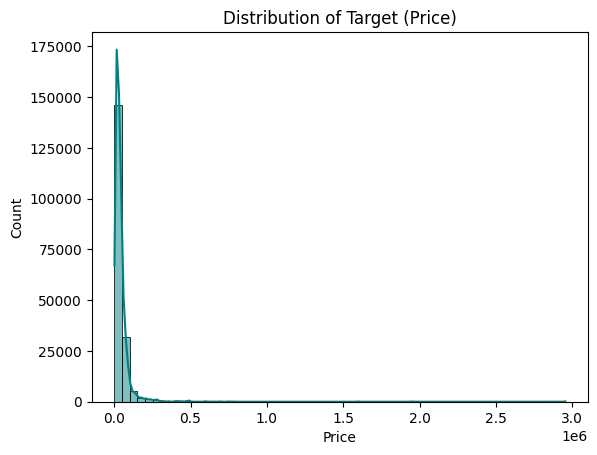

In [ ]:
plt.figure()
sns.histplot(df["price"], bins=59, kde=True, color="teal")
plt.title("Distribution of Target (Price)")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

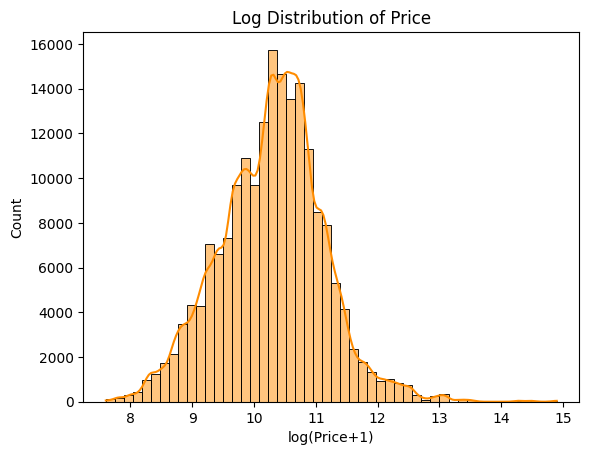

In [ ]:
plt.figure()
sns.histplot(np.log1p(df["price"]), bins=50, kde=True, color="darkorange")
plt.title("Log Distribution of Price")
plt.xlabel("log(Price+1)")
plt.ylabel("Count")
plt.show()

In [ ]:
num_summary = df[NUM_COLS].describe().T
print("\nNumerical Features Summary:\n", num_summary)


Numerical Features Summary:
                           count          mean           std          min  \
milage                 188533.0  65705.295174  49798.158076   100.000000   
accident               188533.0      0.779524      0.414569     0.000000   
engine_hp              188533.0    334.967719    102.502625    70.000000   
engine_displacement_L  188533.0      3.783555      1.306341     0.650000   
model_age              188533.0      9.170002      5.660967     1.000000   
hp_per_litre           188533.0     93.056534     25.389790    27.692303   
brand_popularity       188533.0  11262.807047   7305.903997     2.000000   
model_popularity       188533.0    430.115020    536.568036     1.000000   
brand_mean_price       188533.0  43878.016178  16802.698592  9497.500000   
mileage_per_year       188533.0   6297.850269   3884.780889     4.761905   
color_match            188533.0      0.218391      0.413156     0.000000   
rare_ext_color         188533.0      0.026701      0.16120

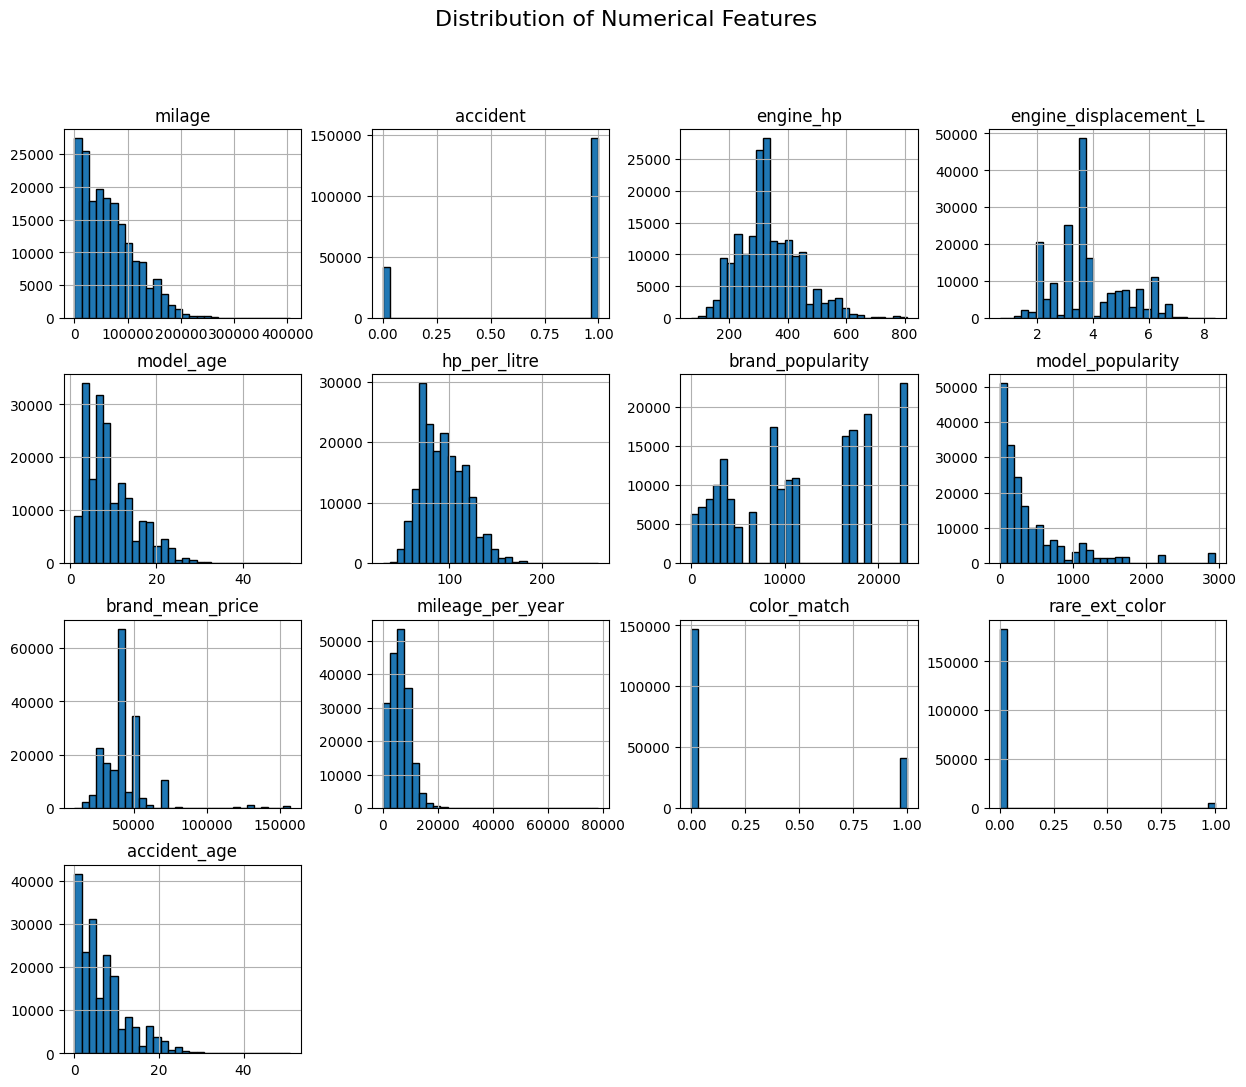

In [ ]:
# Histograms
df[NUM_COLS].hist(bins=30, figsize=(15, 12), edgecolor="black")
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()

In [ ]:
df["brand_popularity"].value_counts()

brand_popularity
23036    23036
19145    19145
17028    17028
16320    16320
10901    10901
10582    10582
9543      9543
8791      8791
8644      8644
6531      6531
4661      4661
4270      4270
3893      3893
3763      3763
3280      3280
3229      3229
3118      3118
2728      2728
2509      2509
2401      2401
2389      2389
2278      2278
2113      2113
2068      2068
1748      1748
1323      1323
1168      1168
1070      1070
949        949
948        948
944        944
821        821
737        737
718        718
687        687
604        604
574        574
557        557
544        544
524        524
350        350
243        243
236        236
154        154
117        117
71          71
55          55
50          50
46          46
22          22
16          16
9            9
8            8
7            7
6            6
4            4
2            2
Name: count, dtype: int64

In [ ]:
for col in CAT_COLS:
    plt.figure()
    order = df[col].value_counts().iloc[:15].index
    sns.countplot(data=df, y=col, order=order, palette="viridis")
    plt.title(f"Top {col} frequencies")
    plt.show()

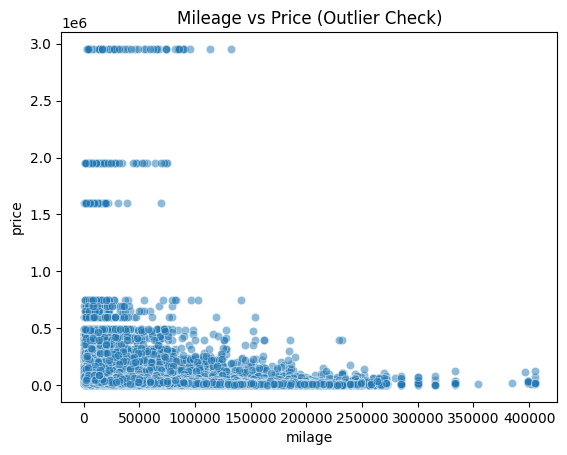

In [ ]:
plt.figure()
sns.scatterplot(data=df, x="milage", y="price", alpha=0.5)
plt.title("Mileage vs Price (Outlier Check)")
plt.show()

<Axes: >

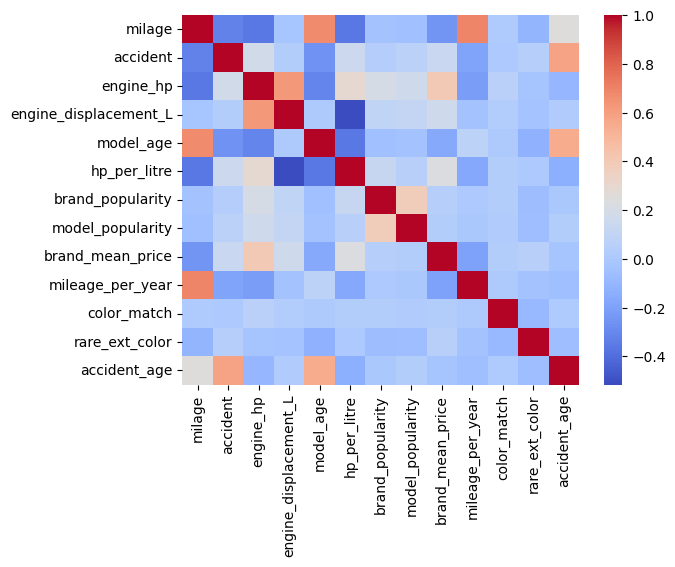

In [ ]:
corr = df[NUM_COLS].corr()
sns.heatmap(corr, cmap="coolwarm")

In [ ]:
# Encode categorical columns for XGBoost (Label Encoding)
for col in CAT_COLS:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
X = df[ALL_FEATURES]
y = df[TARGET]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    "Linear": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

In [ ]:
# Helper function for RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
# -----------------------------
# 1. Evaluate baseline models
# -----------------------------
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    trans_preds = np.expm1(preds)
    trans_y_val = np.expm1(y_val)
    results.append({
        "Model": name,
        "RMSE": rmse(trans_y_val, trans_preds),                           # fixed here
        "MAE": mean_absolute_error(trans_y_val, trans_preds),
        "R2": r2_score(preds, y_val)
    })

results_df = pd.DataFrame(results).sort_values("RMSE")
print("Baseline Models:\n", results_df)

In [ ]:
 # --- Helper: tune XGB model ---
def tune_xgb(X, y, xgb_n_estimators, n_iter, cv):
    # --- PARAMETER DISTRIBUTIONS for random search ---
    param_dist = {
        "max_depth": randint(3, 12),
        "min_child_weight": randint(1, 10),
        "subsample": uniform(0.5, 0.5),          # 0.5–1.0
        "colsample_bytree": uniform(0.5, 0.5),   # 0.5–1.0
        "learning_rate": uniform(0.01, 0.2),     # 0.01–0.21
        "reg_alpha": uniform(0, 10),
        "reg_lambda": uniform(0.1, 10)
    }

    base = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=xgb_n_estimators,
        n_jobs=-1,
        random_state=42
    )
    random_search = RandomizedSearchCV(
        base,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        verbose=0,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X, y.values.ravel())
    return random_search.best_estimator_, random_search.best_params_


In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from dataclasses import dataclass

# Expect tune_xgb(X, y, n_estimators, n_iter, cv) -> (fitted_model, best_params)
# If you don't tune, set tune_global=False / tune_experts=False.
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np
import xgboost as xgb

def tune_xgb(X, y, xgb_n_estimators=600, n_iter=20, cv=3, use_gpu=False, random_state=42):
    # --- robust to pandas or numpy ---
    X_np = X.values if hasattr(X, "values") else np.asarray(X)
    y_np = y.values.ravel() if hasattr(y, "values") else np.asarray(y).ravel()

    base = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=xgb_n_estimators,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        n_jobs=-1,
        random_state=random_state,
        tree_method=("gpu_hist" if use_gpu else "hist"),
    )

    param_dist = {
        "max_depth": randint(3, 12),
        "min_child_weight": randint(1, 10),
        "subsample": uniform(0.5, 0.5),        # 0.5–1.0
        "colsample_bytree": uniform(0.5, 0.5), # 0.5–1.0
        "gamma": uniform(0.0, 0.5),
        "reg_alpha": uniform(0.0, 0.2),
        "learning_rate": uniform(0.01, 0.09),  # 0.01–0.10
    }

    search = RandomizedSearchCV(
        base,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        n_jobs=-1,
        verbose=0,
        scoring="neg_root_mean_squared_error",
        random_state=random_state,
    )
    search.fit(X_np, y_np)
    return search.best_estimator_, search.best_params_

@dataclass
class MoEModels:
    scaler: StandardScaler
    kmeans: KMeans
    experts: dict
    global_model: xgb.XGBRegressor
    global_weight: float

def _to_numpy(X):
    # Works for NumPy arrays or pandas DataFrames
    return X.values if hasattr(X, "values") else np.asarray(X)

def train_moe(
    X_train,
    X_valid,
    y_train,
    n_clusters=10,
    global_weight=0.2,          # weight on GLOBAL model (0..1)
    random_state=42,
    tune_global=True,
    tune_experts=True,
    n_iter=10,
    cv=3,
    xgb_n_estimators=600,
    min_cluster_size=25,
    use_gpu=False               # set True for 'gpu_hist' if available
):
    """
    Mixture of Experts (KMeans on TRAIN features) + per-cluster XGBoost + global XGBoost.
    Returns blended predictions on X_valid and the fitted components.
    """

    # --- 0) Safety & typing ---
    global_weight = float(np.clip(global_weight, 0.0, 1.0))
    X_tr_np = _to_numpy(X_train)
    X_va_np = _to_numpy(X_valid)
    y_tr_np = y_train.values if hasattr(y_train, "values") else np.asarray(y_train).ravel()

    # --- 1) Scale features for KMeans (important for distance-based clustering) ---
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr_np)
    X_va_scaled = scaler.transform(X_va_np)

    # --- 2) Unsupervised clustering on TRAIN only ---
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)
    train_clusters = kmeans.fit_predict(X_tr_scaled)
    valid_clusters = kmeans.predict(X_va_scaled)

    # --- 3) Train GLOBAL model ---
    base_kwargs = dict(
        objective="reg:squarederror",
        n_estimators=xgb_n_estimators,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        n_jobs=-1,
        random_state=random_state,
        tree_method=("gpu_hist" if use_gpu else "hist"),
    )

    if tune_global:
# instead of X_tr_np, y_tr_np:
        global_model, best_global_params = tune_xgb(X_train, y_train, xgb_n_estimators, n_iter, cv)
        print("Best Global Params:", best_global_params)
    else:
        global_model = xgb.XGBRegressor(**base_kwargs)
        global_model.fit(X_tr_np, y_tr_np)

    # --- 4) Train PER-CLUSTER experts ---
    cluster_models = {}
    cluster_sizes = {}
    for c in range(n_clusters):
        idx = (train_clusters == c)
        n_c = int(idx.sum())
        cluster_sizes[c] = n_c

        if n_c < min_cluster_size:
            cluster_models[c] = None  # fall back to global later
            continue

        X_c = X_tr_np[idx]
        y_c = y_tr_np[idx]

        if tune_experts:
            expert, best_expert_params = tune_xgb(X_c, y_c, xgb_n_estimators, n_iter, cv)
            print(f"Best Params for cluster {c}:", best_expert_params)
            cluster_models[c] = expert
        else:
            expert = xgb.XGBRegressor(**base_kwargs)
            expert.fit(X_c, y_c)
            cluster_models[c] = expert

    # --- 5) Predict + Blend on VALID ---
    # Expert predictions per sample based on its VALID cluster
    cluster_pred = np.zeros(len(X_va_np), dtype=float)
    for c in range(n_clusters):
        vidx = (valid_clusters == c)
        if not np.any(vidx):
            continue
        expert = cluster_models.get(c, None)
        if expert is None:
            cluster_pred[vidx] = global_model.predict(X_va_np[vidx])
        else:
            cluster_pred[vidx] = expert.predict(X_va_np[vidx])

    global_pred = global_model.predict(X_va_np)
    blended_pred = (1.0 - global_weight) * cluster_pred + global_weight * global_pred

    models = MoEModels(
        scaler=scaler,
        kmeans=kmeans,
        experts=cluster_models,
        global_model=global_model,
        global_weight=global_weight,
    )
    return blended_pred, models

def predict_moe(models: MoEModels, X):
    """
    Predict on ANY new feature set using fitted MoE.
    """
    X_np = _to_numpy(X)
    X_scaled = models.scaler.transform(X_np)
    clusters = models.kmeans.predict(X_scaled)

    # Per-cluster expert preds (fallback to global if missing)
    cluster_pred = np.zeros(len(X_np), dtype=float)
    for c in range(models.kmeans.n_clusters):
        vidx = (clusters == c)
        if not np.any(vidx):
            continue
        expert = models.experts.get(c, None)
        if expert is None:
            cluster_pred[vidx] = models.global_model.predict(X_np[vidx])
        else:
            cluster_pred[vidx] = expert.predict(X_np[vidx])

    global_pred = models.global_model.predict(X_np)
    return (1.0 - models.global_weight) * cluster_pred + models.global_weight * global_pred


In [ ]:
# -----------------------------
# 2. Evaluate MoE model
# -----------------------------
moe_preds, _ = train_moe(X_train, X_val, y_train)

trans_y_val = np.expm1(y_val)
trans_moe_preds = np.expm1(moe_preds)

moe_rmse = rmse(trans_y_val.values, trans_moe_preds)
moe_mae  = mean_absolute_error(trans_y_val.values, trans_moe_preds)
moe_r2   = r2_score(y_val, moe_preds)

results_df.loc[len(results_df)] = ["MoE-XGBoost", moe_rmse, moe_mae, moe_r2]

# Final leaderboard
results_df = results_df.sort_values("RMSE").reset_index(drop=True)
print("\nFinal Leaderboard:\n", results_df)